In [1]:
import os
import sys

import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def calibration_parameters(path, cshape):
    """Compute calibration parameters from a set of calibration images.
    
    Params:
      path: Directory of calibration images.
      cshape: Shape of grid used in the latter.
    Return:
      mtx, dist
    """
    # Object / image points collections.
    objpoints = []
    imgpoints = []

    # Calibration points from images.
    filenames = os.listdir(path)
    for fname in filenames:
        img = cv2.imread(path + fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Theoretical Grid.
        objp = np.zeros((cshape[0] * cshape[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:cshape[0], 0:cshape[1]].T.reshape(-1, 2)
        # Corners in the image.
        ret, corners = cv2.findChessboardCorners(gray, cshape, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('Warning! Not chessboard found in the image', fname)
    
    # Calibration from image points.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

In [4]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = calibration_parameters(path, cshape)

Warning! Not chessboard found in the image calibration1.jpg
Warning! Not chessboard found in the image calibration4.jpg
Warning! Not chessboard found in the image calibration5.jpg


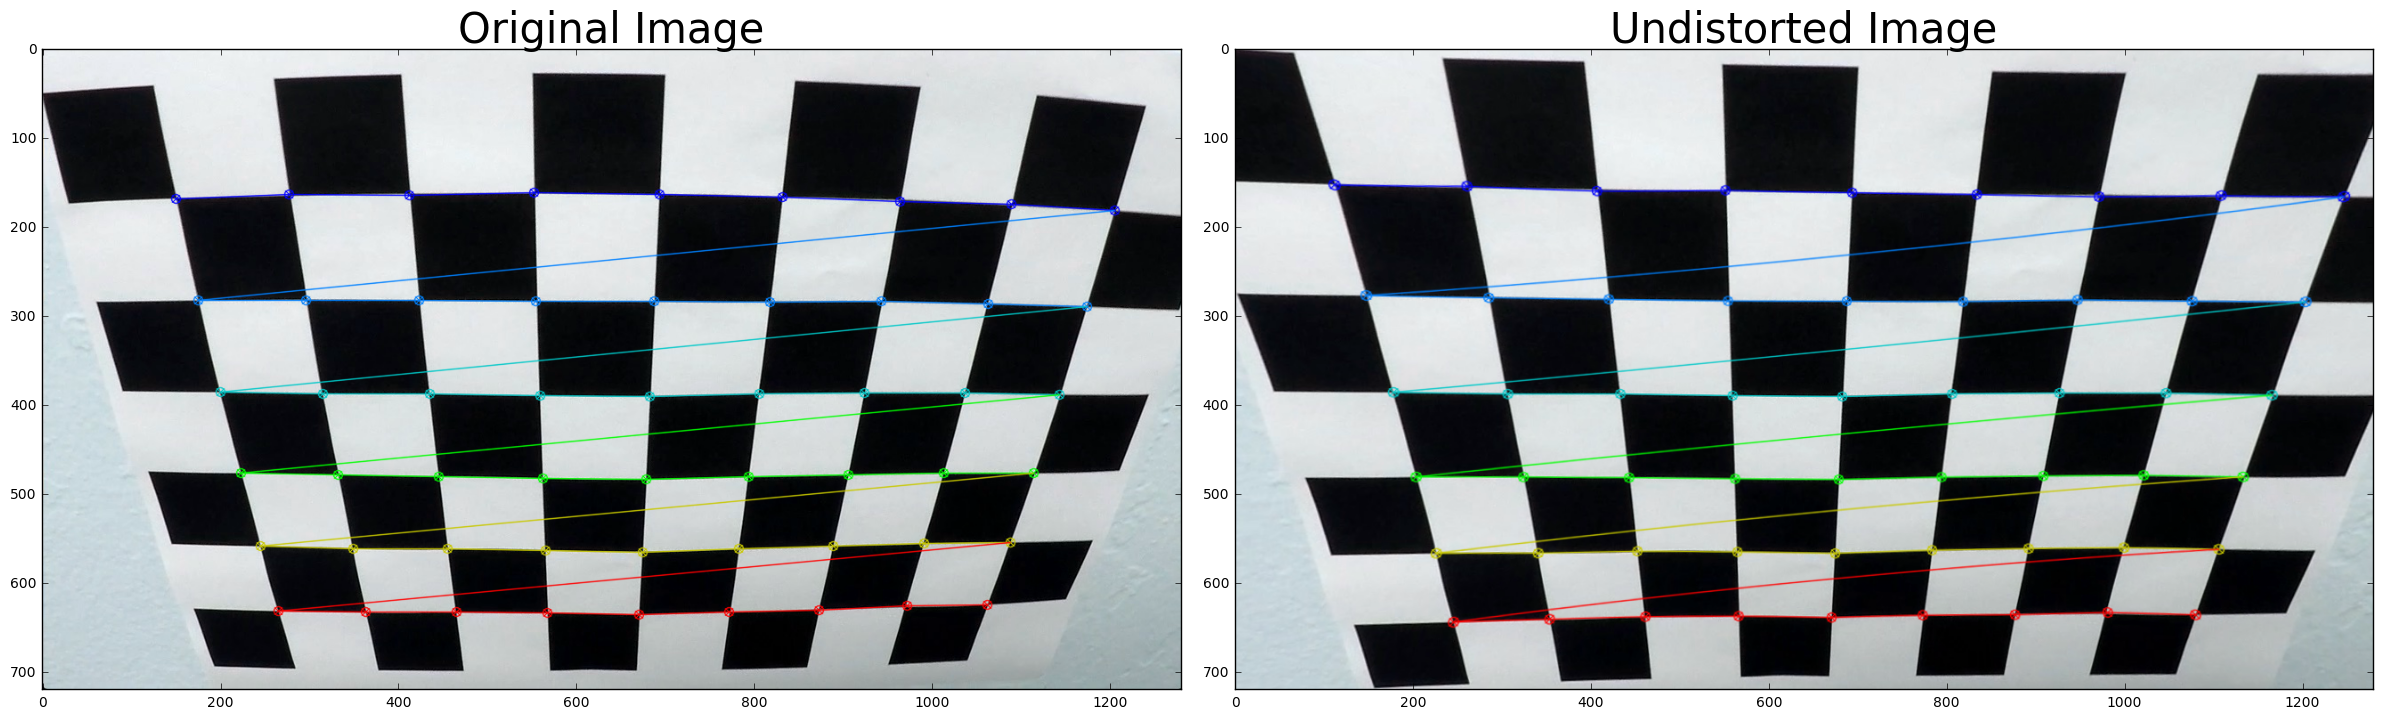

In [5]:
# Test the calibration on some image.
filenames = os.listdir(path)
img = cv2.imread(path + filenames[11])
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cshape, None)
img = cv2.drawChessboardCorners(img, cshape, corners, ret)
undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
def load_image(filename, crop_shape=(720, 1280)):
    """Load an image, and crop it to the correct shape if necessary.
    """
    img = mpimg.imread(filename)
    shape = img.shape
    # Cropping.
    if shape[0] > crop_shape[0]:
        img = img[-crop_shape[0]:, :, :]
    if shape[1] > crop_shape[1]:
        img = img[:, :crop_shape[1], :]
    return img

In [17]:
def gradient_magnitude(gray, sobel_kernel=3):
    """Compute mask based on gradient magnitude. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Norm and rescaling (c.f. different kernel sizes)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_x(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6), iterations=3):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)
    
#     iterations=4
    mid=dilate_kernel[1] // 2
    # Dilate mask to the left.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.
    # Dilate mask to the right.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)
    
    # Eroding a bit
    kernel = np.ones((1,5),np.uint8)
    dmask = cv2.erode(dmask, kernel, iterations=1)
    return dmask
    

def mask_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask


def color_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask

In [69]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_mask(img, mask, color=[255, 0, 0], α=0.8, β=1., λ=0.):
    """The result image is computed as follows: img * α + mask * β + λ
    where mask is transformed into an RGB image.
    """
    mask = (mask > 0).astype(np.uint8)
    color_mask = np.dstack((color[0] * mask, color[1] * mask, color[2] * mask))
    return cv2.addWeighted(img, α, color_mask, β, λ)

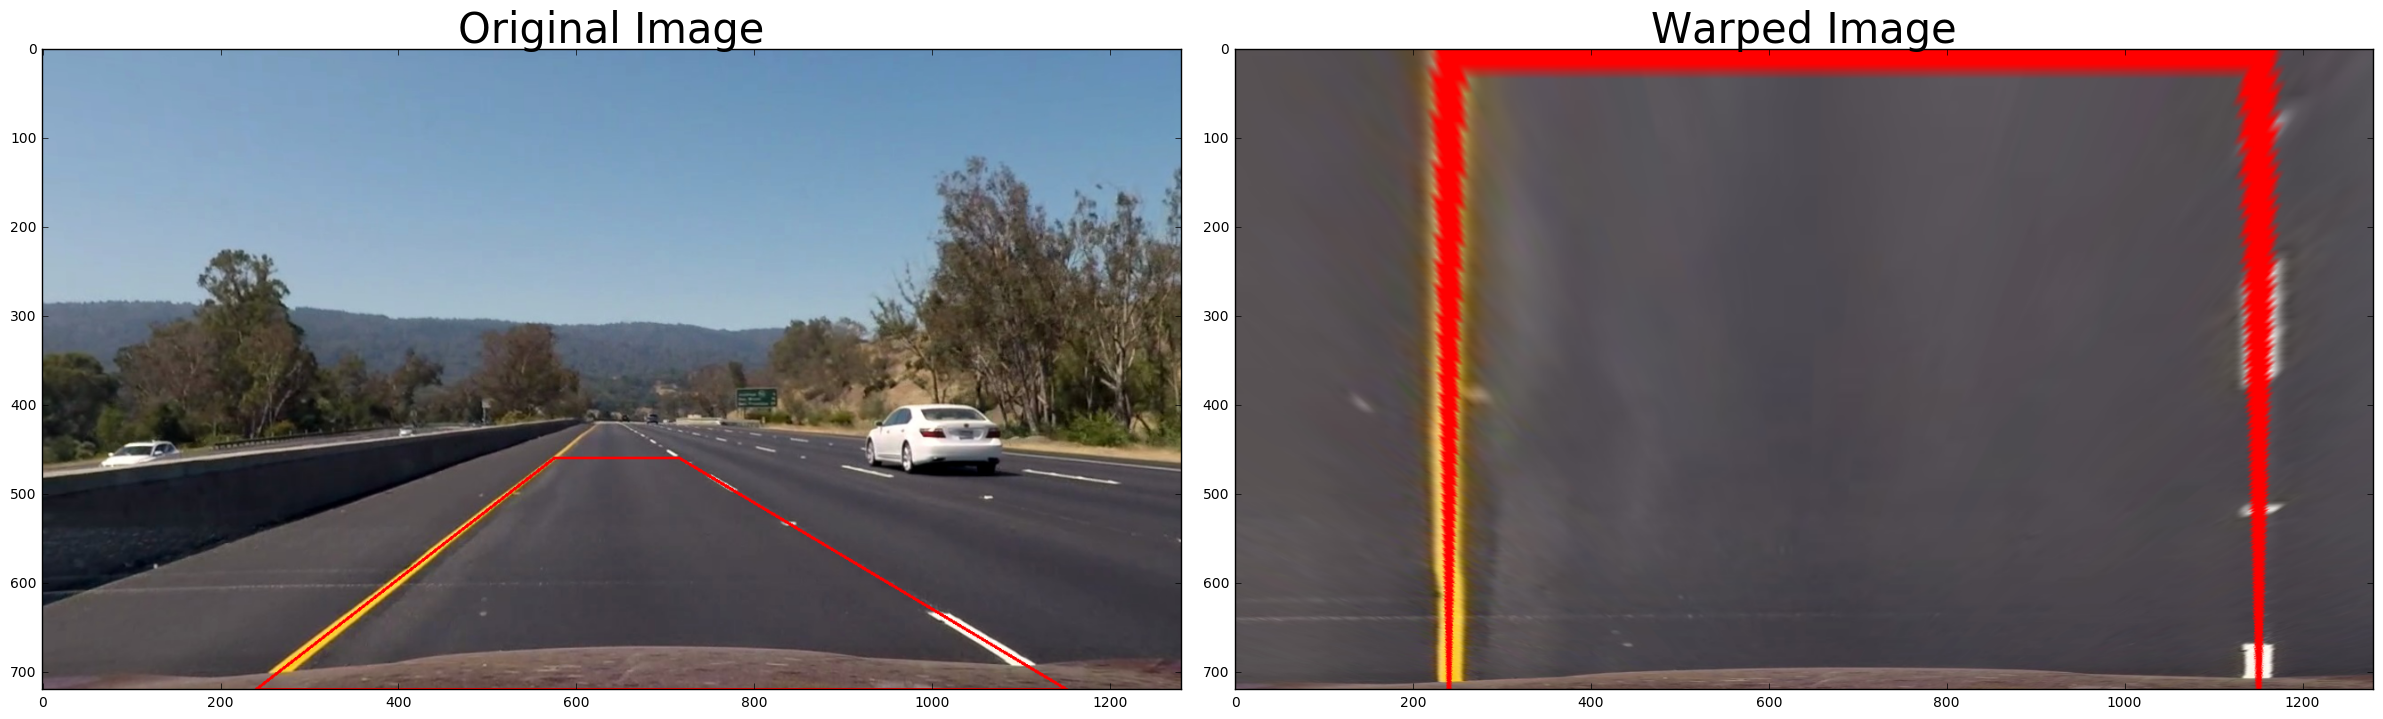

In [59]:
# Reference image for perspective transform.
filename = 'test_images/perspective.jpg'
img = load_image(filename)
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

# Source points for perspective transform.
src_points = [[240, 720],
              [575, 460],
              [715, 460],
              [1150, 720]]
src_points = np.array(src_points, dtype=np.float32)
# Destination points: keep same image size.
dst_points = [[240, 720],
              [240, 0],
              [1150, 0],
              [1150, 720]]
dst_points = np.array(dst_points, dtype=np.float32)

# Perspective transform (and inverse)
m_perp = cv2.getPerspectiveTransform(src_points, dst_points)
m_inv_perp = cv2.getPerspectiveTransform(dst_points, src_points)

# Print lines!
l = len(src_points)
lines = [ [[src_points[i][0], src_points[i][1], src_points[(i+1)%l][0], src_points[(i+1)%l][1]]] for i in range(l)]
draw_lines(img, lines, thickness=2)

# Apply transform.
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(wimg)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

In [60]:
points = src_points
points = [[0., 0.]]

original = np.array([points], dtype=np.float32)
print(original.shape)
cv2.perspectiveTransform(original, m_perp)

(1, 1, 2)


array([[[ 1109.3392334 ,   948.37005615]]], dtype=float32)

In [61]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
print(filenames)

['perspective.jpg', 'signs_vehicles_xygrad.jpg', 'test (1).jpg', 'test (10).jpg', 'test (11).jpg', 'test (12).jpg', 'test (13).jpg', 'test (14).jpg', 'test (15).jpg', 'test (16).jpg', 'test (17).jpg', 'test (18).jpg', 'test (19).jpg', 'test (2).jpg', 'test (3).jpg', 'test (4).jpg', 'test (5).jpg', 'test (6).jpg', 'test (7).jpg', 'test (8).jpg', 'test (9).jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


test_images/test (1).jpg (720, 1280, 3)


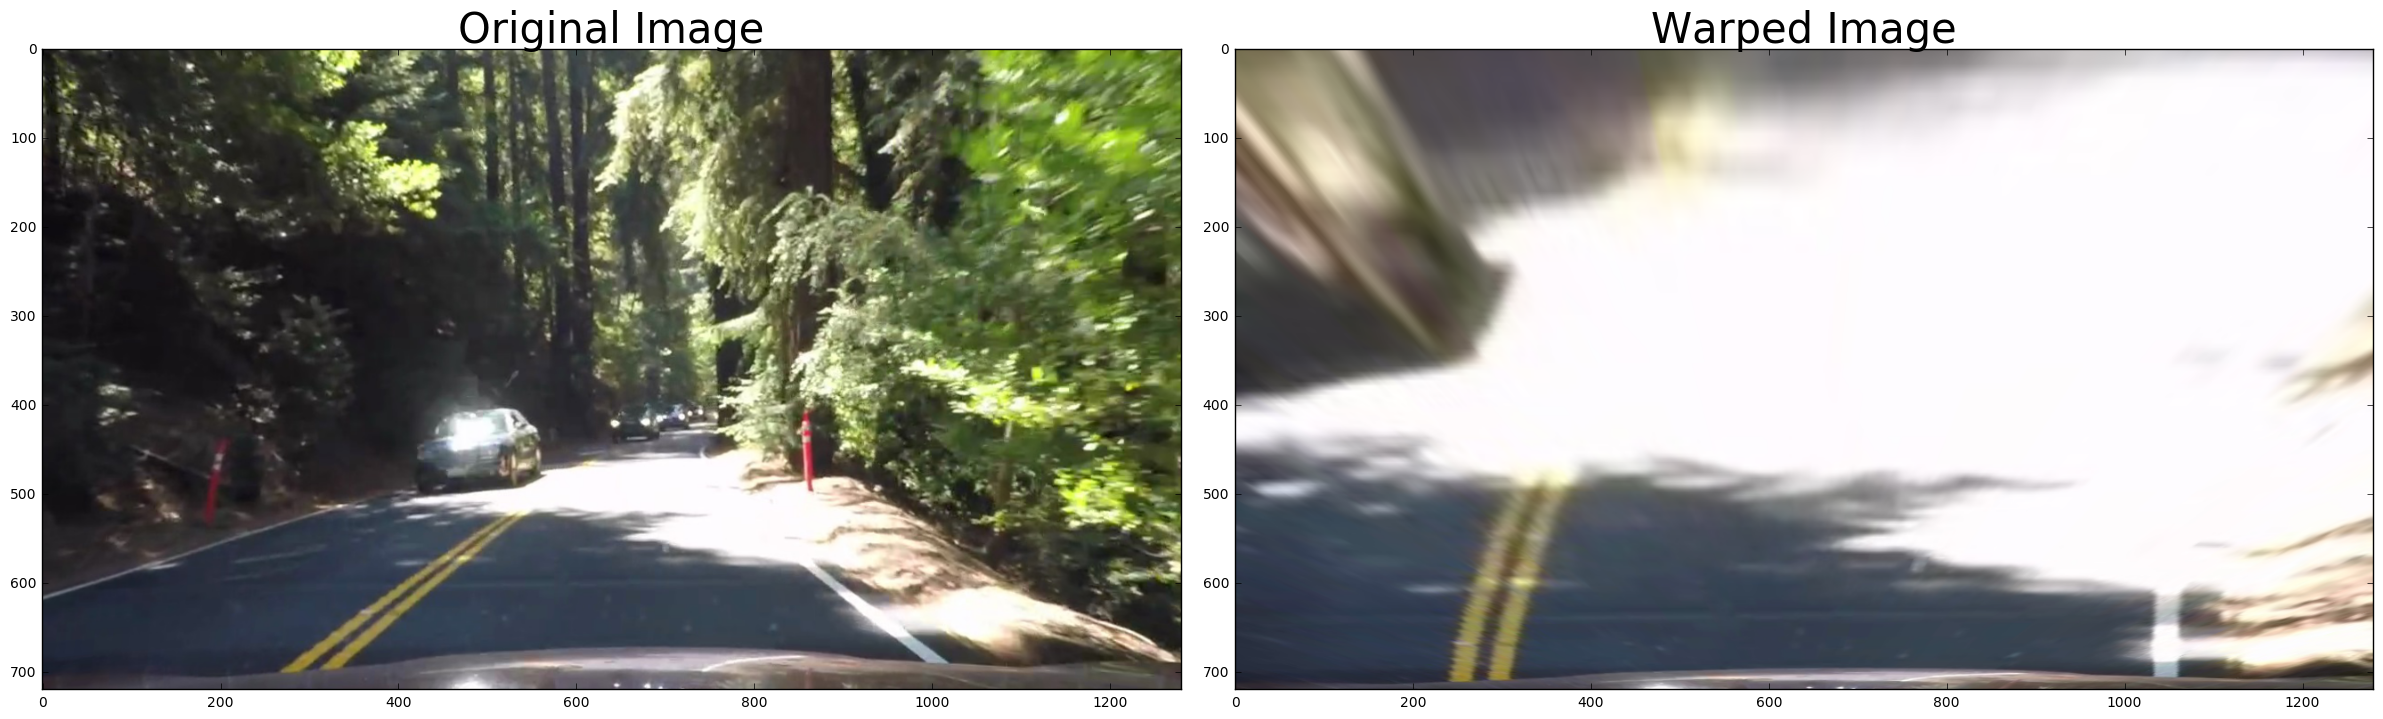

In [292]:
# Test on some image...
filename = path + os.listdir(path)[2]
img = load_image(filename)
img = cv2.undistort(img, mtx, dist, None, mtx)
print(filename, img.shape)
undst = img

# Warped image.
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(wimg)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

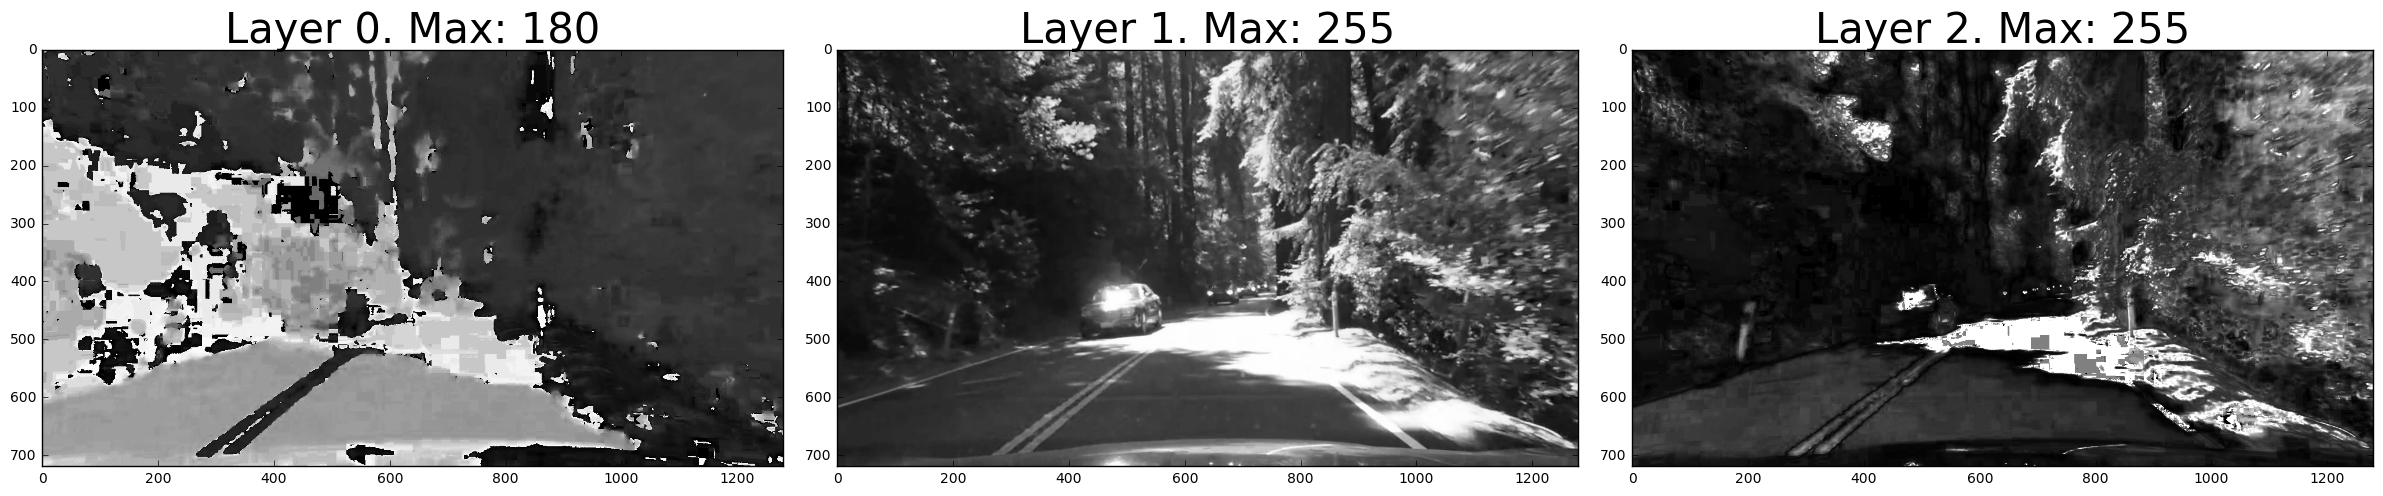

In [293]:
ungray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)
unhsl = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS)
# unhsl = cv2.cvtColor(undst, cv2.COLOR_RGB2YUV)

f, axes = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
for i in range(3):
    axes[i].imshow(unhsl[:, :, i], cmap='gray')
    axes[i].set_title('Layer %i. Max: %i' % (i, np.max(unhsl[:, :, i])), fontsize=30)
plt.show()



In [294]:
def warped_masks(img, m_perp):
    """Generate a collection of masks for lines.
    Note: a collection can be useful to then compute weights.
    """
    # Grayscale and HSL.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Compute x gradients.
    skernel = -1
    sobel_dx = gradient_x(gray, sobel_kernel=skernel)
    s_sobel_dx = gradient_x(hsl[:, :, 2], sobel_kernel=skernel)
    # sobel_mag = gradient_magnitude(ungray, sobel_kernel=5)
    
    # Warped gradient fields.
    wsobel_dx = cv2.warpPerspective(sobel_dx, m_perp, img_size, flags=cv2.INTER_LANCZOS4)
    ws_sobel_dx = cv2.warpPerspective(s_sobel_dx, m_perp, img_size, flags=cv2.INTER_LANCZOS4)

    # Construct warped masks
    wmasks = []
    wmasks.append(mask_local_crossing_x(wsobel_dx, threshold=15, dilate_kernel=(1, 8), iterations=4))
    wmasks.append(mask_local_crossing_x(ws_sobel_dx, threshold=15, dilate_kernel=(1, 8), iterations=4))

    # masks.append(mask_threshold(sobel_mag, threshold=(50, 255)))
    # masks.append(mask_threshold(s_sobel_mag, threshold=(30, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    
    return wmasks

def default_left_right_masks(img, margin=0.1):
    """Default left and right masks used to find lanes: middle split with some additional margin.
    """
    shape = img.shape[0:2]
    llimit = int(shape[1] / 2 + shape[1] * margin)
    rlimit = int(shape[1] / 2 - shape[1] * margin)
    
    # Mask from meshgrid.
    xv, yv = np.mgrid[0:shape[0], 0:shape[1]]
    lmask = yv <= llimit
    rmask = yv >= rlimit
    
    return lmask, rmask


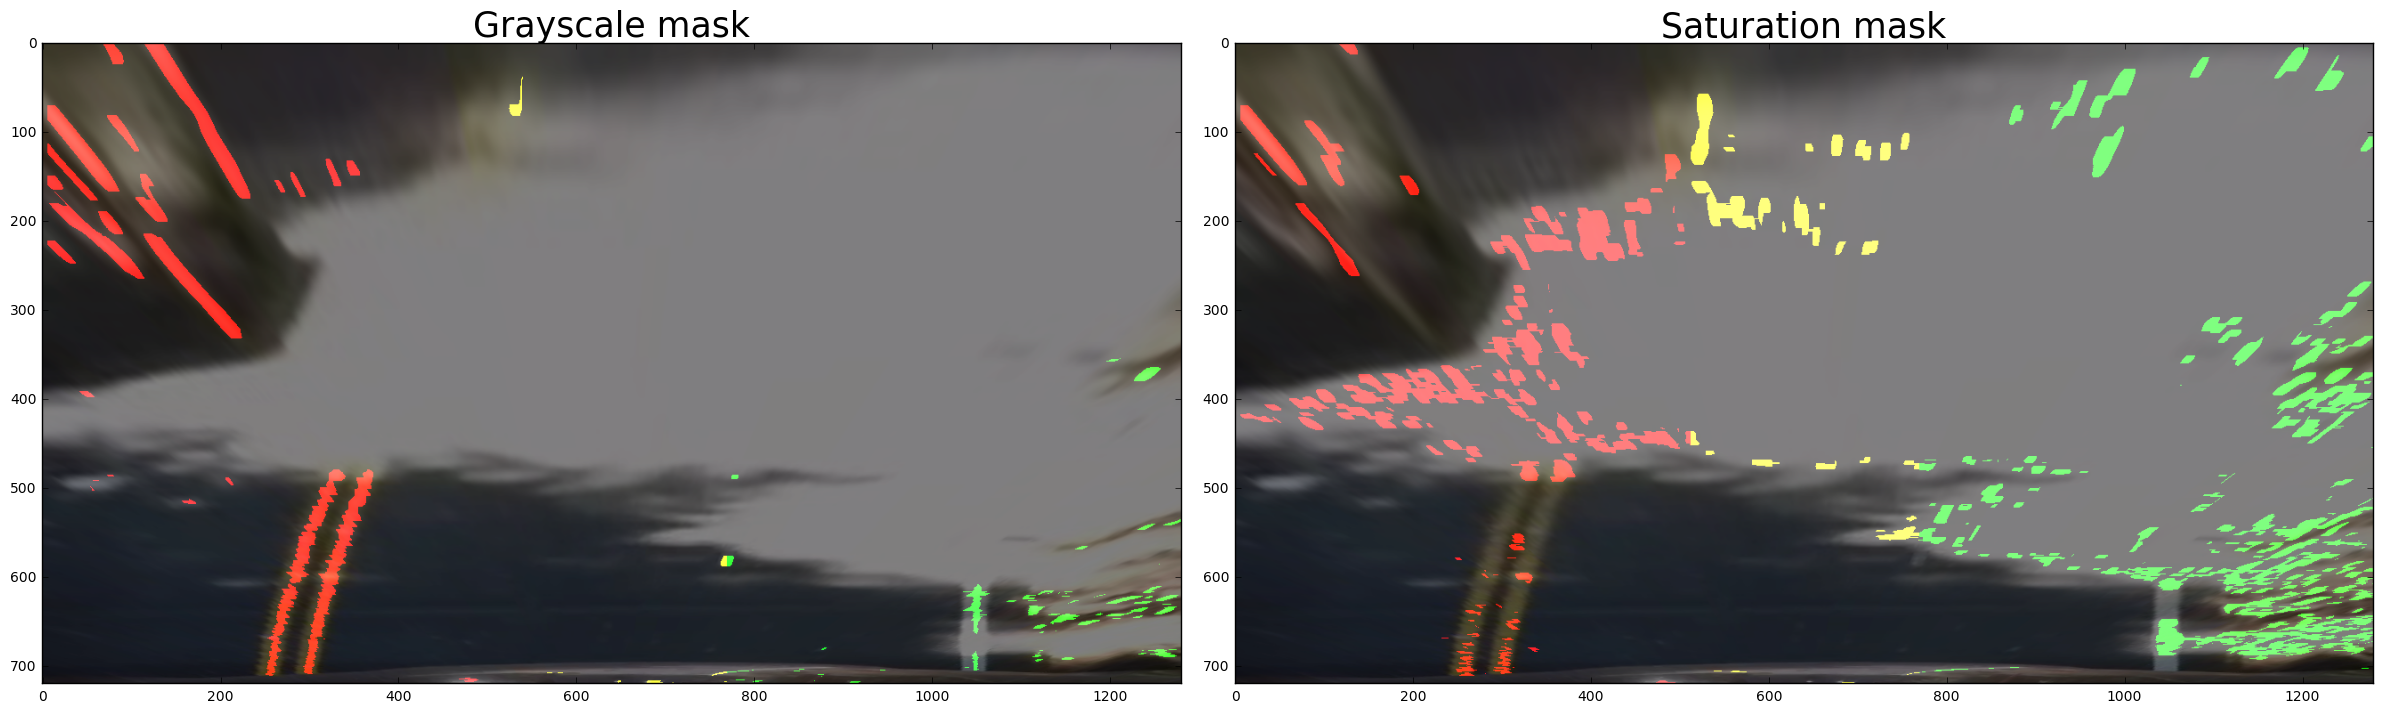

In [295]:
# Compute warped masks...
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, m_perp)

lmask, rmask = default_left_right_masks(img, margin=0.1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# ax1.imshow(wmasks[0], cmap='gray')
masked_img = draw_mask(wimg, wmasks[0] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
masked_img = draw_mask(masked_img, wmasks[0] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
ax1.imshow(masked_img)
ax1.set_title('Grayscale mask', fontsize=25)

masked_img = draw_mask(wimg, wmasks[1] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
masked_img = draw_mask(masked_img, wmasks[1] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
ax2.imshow(masked_img)
ax2.set_title('Saturation mask', fontsize=25)
plt.show()
    

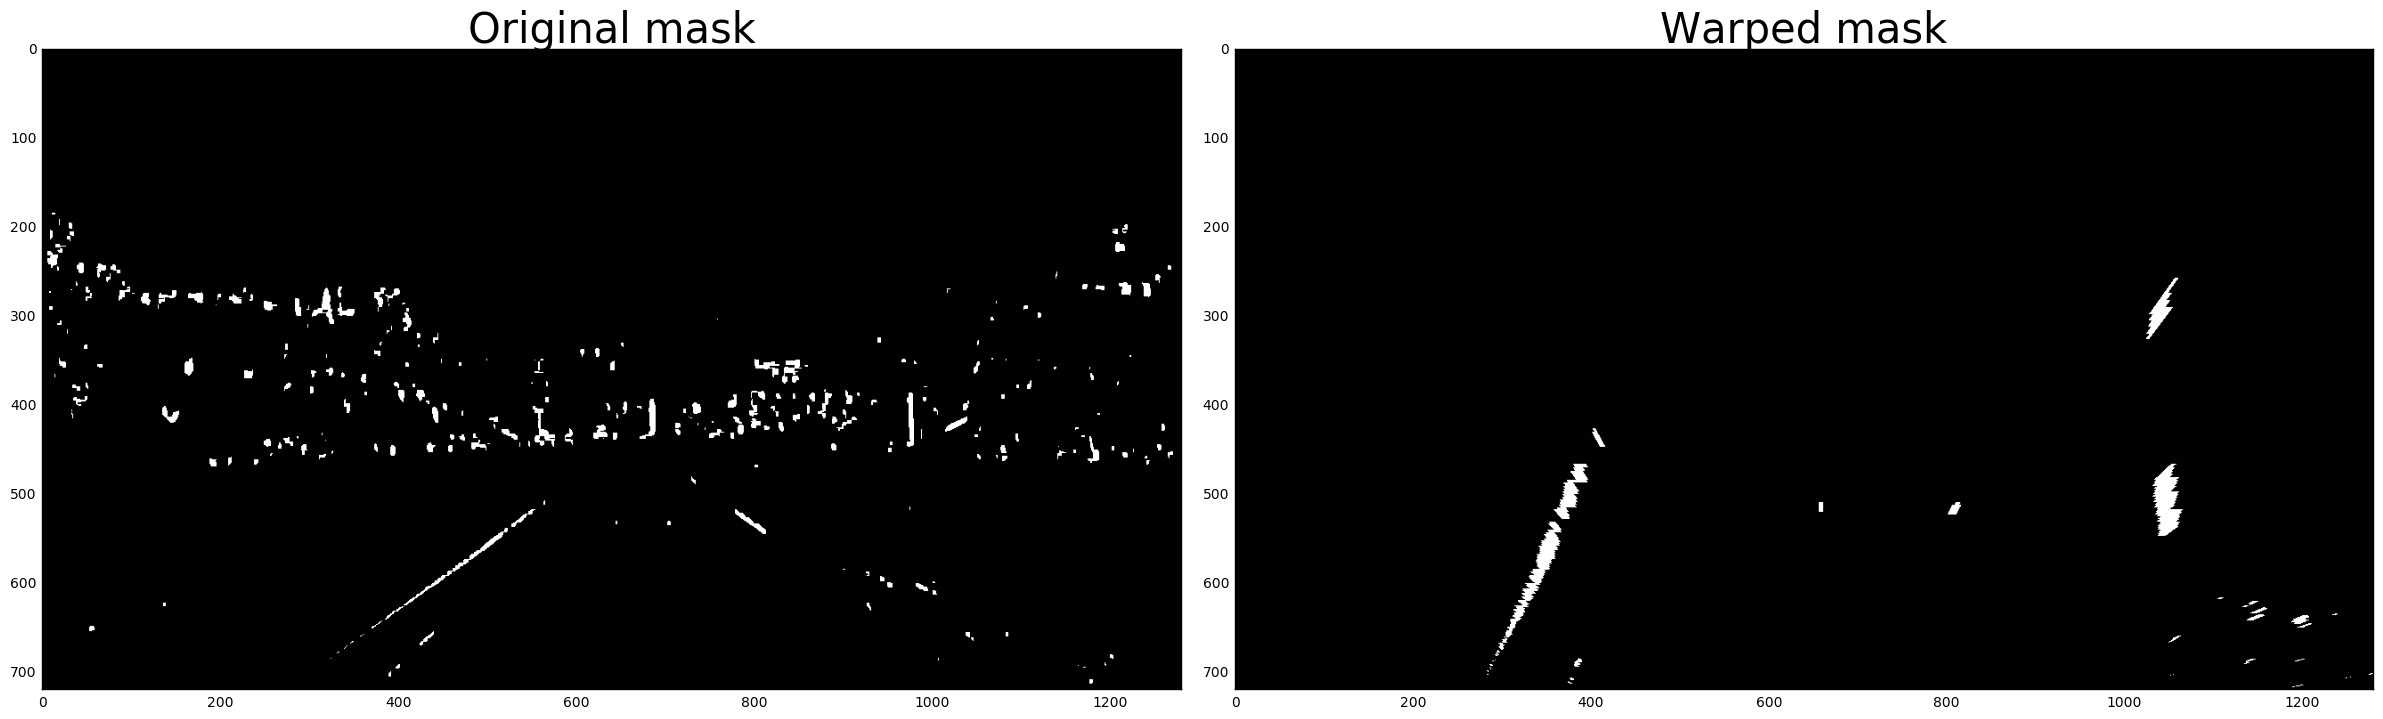

(11538,)


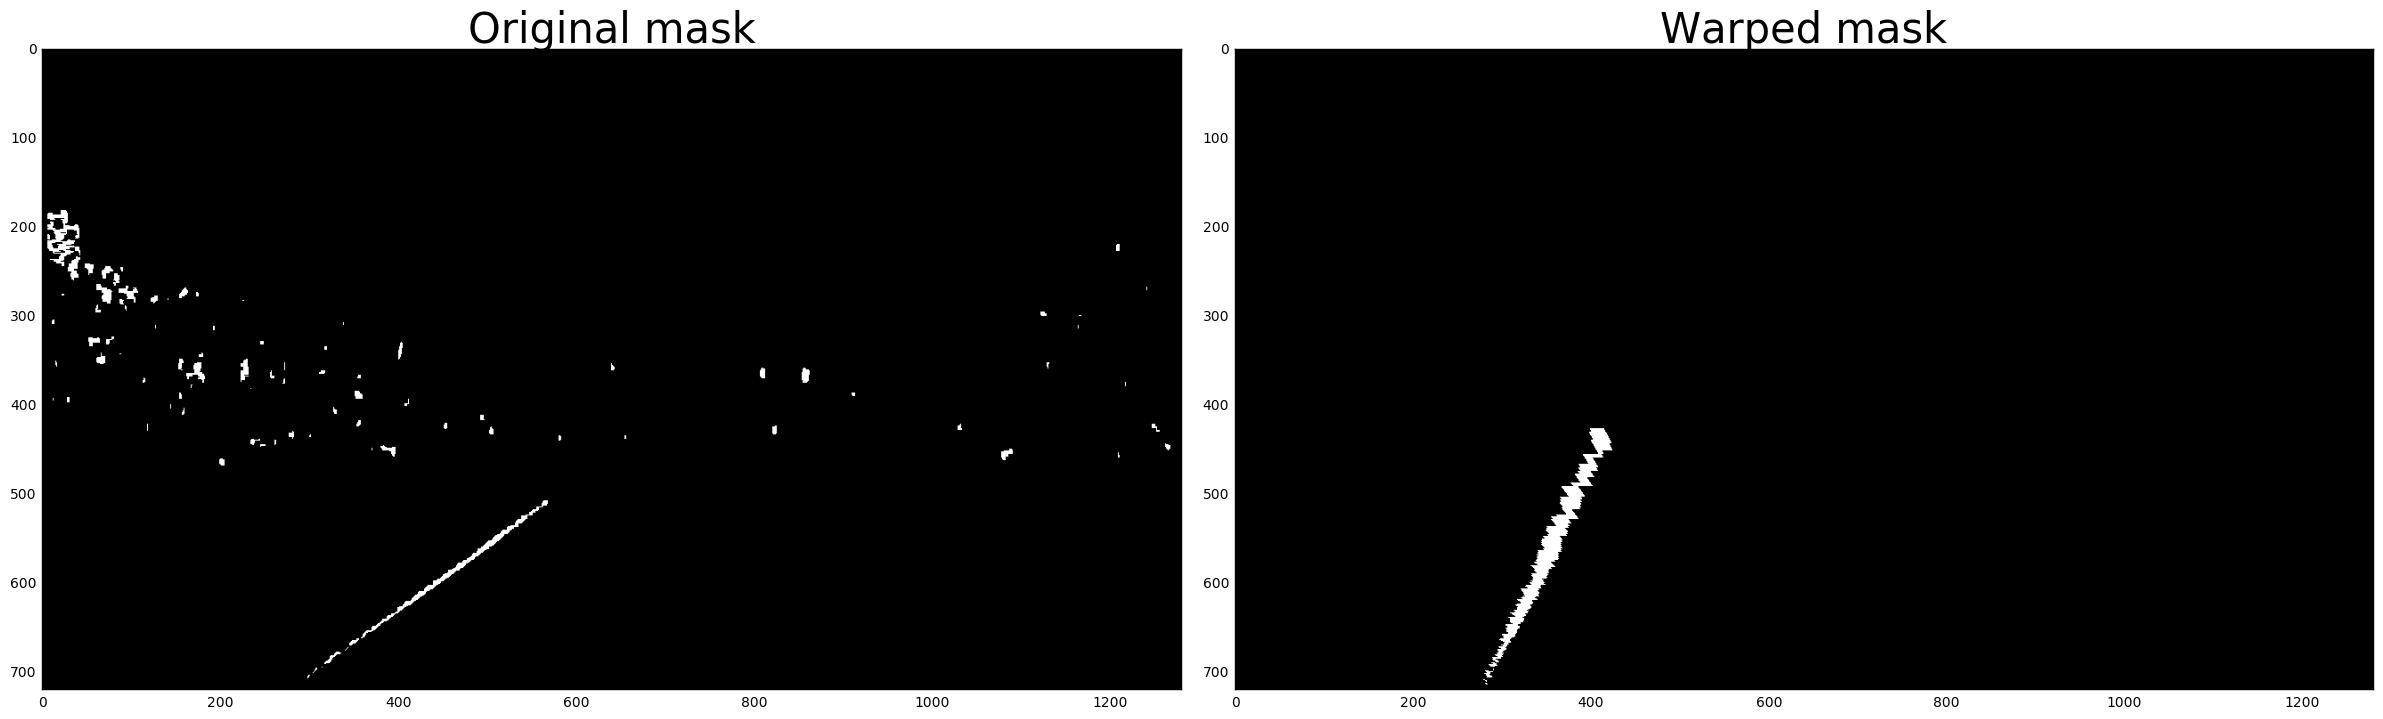

(5286,)


In [275]:
for i, m in enumerate(masks):
    
    # Warped mask.
    wm = cv2.warpPerspective(m, m_perp, img_size, flags=cv2.INTER_NEAREST)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(m, cmap='gray')
    ax1.set_title('Original mask', fontsize=30)
    ax2.imshow(wm, cmap='gray')
    ax2.set_title('Warped mask', fontsize=30)
    plt.show()
    
    print(np.where(m)[0].shape)